# Question 01

In [24]:
import pandas as pd 
import numpy as np
import requests 
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [25]:
req = requests.get('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1012118802') 
soup = BeautifulSoup(req.content,'lxml') 
table = soup.find_all('table')[0]  
df = pd.read_html(str(table)) 
df_neighbourhood = pd.DataFrame(df[0]) 

In [26]:
# Delete not assigned Boroughs
df_neighbourhood = df_neighbourhood[df_neighbourhood['Borough'] != 'Not assigned']

In [27]:
# Amount of neighbourhoods with Not assigned
df_neighbourhood[df_neighbourhood.Neighbourhood == 'Not assigned'].count()

Postal Code      0
Borough          0
Neighbourhood    0
dtype: int64

In [28]:
# Check if there are duplicities in Postal code (True -> unique values)
df_neighbourhood['Postal Code'].unique().shape[0] == df_neighbourhood.shape[0]

True

In [29]:
df_neighbourhood.head(5)

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [30]:
df_neighbourhood.shape

(103, 3)

# Question 02

In [31]:
# Geoloader does not work
'''
import geocoder
saved_column = df_neighbourhood['Postal Code']
saved_column.head()
lat_lng_coords = None
while(lat_lng_coords is None):

   g = geocoder.google('{}, Toronto, Ontario'.format(saved_column))

   lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]

longitude = lat_lng_coords[1]

print(latitude, longitude)
'''

"\nimport geocoder\nsaved_column = df_neighbourhood['Postal Code']\nsaved_column.head()\nlat_lng_coords = None\nwhile(lat_lng_coords is None):\n\n   g = geocoder.google('{}, Toronto, Ontario'.format(saved_column))\n\n   lat_lng_coords = g.latlng\n\nlatitude = lat_lng_coords[0]\n\nlongitude = lat_lng_coords[1]\n\nprint(latitude, longitude)\n"

In [32]:
url_csv = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
geo =pd.read_csv(url_csv)

In [33]:
df_geo = df_neighbourhood.merge(geo, on='Postal Code', how='left')
df_geo.head(5)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# Question 03

### Initial visualization

In [34]:
mapTor = folium.Map(location=[df_geo.Latitude[0], df_geo.Longitude[0]], zoom_start=11)
for lat, lng, borough, neighborhood in zip(df_geo['Latitude'], df_geo['Longitude'], df_geo['Borough'], df_geo['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapTor)  
    
mapTor

### Getting Foursquare venues

In [38]:
cred = pd.read_csv('Foursquare_credentials.csv')
CLIENT_ID = cred.Value[0]
CLIENT_SECRET = cred.Value[1]
VERSION = '20180605'
LIMIT = 20

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
Toronto_venues = getNearbyVenues(names=df_geo['Neighbourhood'],
                                   latitudes=df_geo['Latitude'],
                                   longitudes=df_geo['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [41]:
print(Toronto_venues.shape)
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.head()

(1076, 7)
There are 220 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [42]:
# Adjust encoding

onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# new df with top 15 venues

num_top_venues = 15
indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Yoga Studio,Moving Target,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Museum
1,"Alderwood, Long Branch",Pizza Place,Playground,Pool,Gym,Coffee Shop,Pharmacy,Sandwich Place,Pub,Mobile Phone Shop,Movie Theater,Motel,Modern European Restaurant,Mexican Restaurant,Miscellaneous Shop,Middle Eastern Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Restaurant,Middle Eastern Restaurant,Pizza Place,Mobile Phone Shop,Shopping Mall,Fried Chicken Joint,Supermarket,Sushi Restaurant,Sandwich Place,Gas Station,Bridal Shop,Deli / Bodega
3,Bayview Village,Bank,Chinese Restaurant,Japanese Restaurant,Café,Yoga Studio,New American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Moving Target,Museum
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Comfort Food Restaurant,Café,Restaurant,Juice Bar,Liquor Store,Butcher,Thai Restaurant,Pub,Greek Restaurant,Grocery Store,Indian Restaurant,American Restaurant


### Creating 7 clusters based on 15 top values

In [44]:
kclusters = 7

grouped_clustering = grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 5, 1, 1, 1, 1, 0, 5, 3, 1, 1, 1, 1,
       2, 1, 2, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 5, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 5, 5, 1, 1, 5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 6, 5,
       1, 1, 2, 1, 5, 1, 1, 2])

In [45]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
merged = df_geo.merge(neighborhoods_venues_sorted, left_on='Neighbourhood', right_on='Neighborhood', how='inner')
merged.head() 

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2,Parkwoods,Fast Food Restaurant,Food & Drink Shop,Park,...,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Museum
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Victoria Village,Financial or Legal Service,Coffee Shop,Hockey Arena,...,Music Venue,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Moving Target
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,"Regent Park, Harbourfront",Coffee Shop,Breakfast Spot,Park,...,Historic Site,Bakery,Performing Arts Venue,Gym / Fitness Center,Pub,Dessert Shop,Distribution Center,Restaurant,Chocolate Shop,Motel
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,"Lawrence Manor, Lawrence Heights",Clothing Store,Furniture / Home Store,Women's Store,...,Boutique,Vietnamese Restaurant,Accessories Store,Pharmacy,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Plane,Mobile Phone Shop,Modern European Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,"Queen's Park, Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Yoga Studio,...,Fried Chicken Joint,Mexican Restaurant,Distribution Center,Diner,Park,Creperie,Salad Place,Burrito Place,Burger Joint,Beer Bar


### Final visualization and clusted descriptions

In [57]:
# create map
map_clusters = folium.Map(location=[df_geo.Latitude[0], df_geo.Longitude[0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighbourhood'], merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [47]:
# Cluster descriptions
# choose cluster number from 0 to 6
cluster_number = 5

merged.loc[merged['Cluster Labels'] == cluster_number, merged.columns[[1] + list(range(5, merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
8,East York,5,"Parkview Hill, Woodbine Gardens",Pizza Place,Intersection,Athletics & Sports,Flea Market,Pharmacy,Pet Store,Gym / Fitness Center,Furniture / Home Store,Gastropub,Breakfast Spot,Bank,Motel,Modern European Restaurant,Yoga Studio,Mobile Phone Shop
10,North York,5,Glencairn,Japanese Restaurant,Pizza Place,Bakery,Asian Restaurant,Music Venue,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Moving Target,Museum
31,Scarborough,5,Scarborough Village,Playground,Pizza Place,Museum,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Moving Target,Music Venue
50,North York,5,Humber Summit,Pizza Place,Intersection,Yoga Studio,Museum,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Movie Theater,Moving Target,New American Restaurant
68,Etobicoke,5,Westmount,Sandwich Place,Chinese Restaurant,Discount Store,Pizza Place,Coffee Shop,Middle Eastern Restaurant,Intersection,Museum,Moving Target,Movie Theater,Yoga Studio,Motel,Music Venue,Mobile Phone Shop,Miscellaneous Shop
70,North York,5,"Willowdale, Willowdale West",Butcher,Pizza Place,Coffee Shop,Pharmacy,Grocery Store,Supermarket,Mobile Phone Shop,Moving Target,Movie Theater,Motel,Modern European Restaurant,Yoga Studio,Miscellaneous Shop,Museum,Mexican Restaurant
80,Scarborough,5,"Clarks Corners, Tam O'Shanter, Sullivan",Pizza Place,Noodle House,Chinese Restaurant,Gas Station,Thai Restaurant,Fried Chicken Joint,Italian Restaurant,Bank,Fast Food Restaurant,Pharmacy,Miscellaneous Shop,Movie Theater,Middle Eastern Restaurant,Mexican Restaurant,Mobile Phone Shop
87,Etobicoke,5,"South Steeles, Silverstone, Humbergate, Jamest...",Grocery Store,Sandwich Place,Pizza Place,Pharmacy,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Moving Target,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel
88,Scarborough,5,"Steeles West, L'Amoreaux West",Fast Food Restaurant,Coffee Shop,Bank,Chinese Restaurant,Supermarket,Sandwich Place,Pharmacy,Pizza Place,Breakfast Spot,Cosmetics Shop,Miscellaneous Shop,Museum,Mobile Phone Shop,Modern European Restaurant,Motel
91,Etobicoke,5,"Alderwood, Long Branch",Pizza Place,Playground,Pool,Gym,Coffee Shop,Pharmacy,Sandwich Place,Pub,Mobile Phone Shop,Movie Theater,Motel,Modern European Restaurant,Mexican Restaurant,Miscellaneous Shop,Middle Eastern Restaurant


In [ ]:
### Figure screenshot in case maps don't show

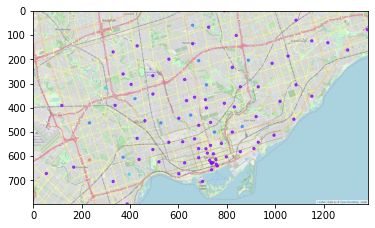

In [59]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("Saved_clusters.jpg")
plt.imshow(image)
plt.show()